In [1]:
import roboticstoolbox as rtb
from spatialmath import SE3
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
ur3 = rtb.models.DH.UR3()

# config = ur3.config_validate("ldn", ('lr', 'ud', 'nf'))

print(ur3)
# T_approach = SE3.Trans(0.4, 0.0, 0.25) * SE3.RPY([0, 0, 0]) 
# ur3.ikine_LM(T_approach, config)

DHRobot: UR3 (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌────┬─────────┬─────────┬────────┐
│θⱼ  │   dⱼ    │   aⱼ    │   ⍺ⱼ   │
├────┼─────────┼─────────┼────────┤
│ q1 │  0.1519 │       0 │  90.0° │
│ q2 │       0 │ -0.2437 │   0.0° │
│ q3 │       0 │ -0.2132 │   0.0° │
│ q4 │  0.1124 │       0 │  90.0° │
│ q5 │ 0.08535 │       0 │ -90.0° │
│ q6 │  0.0819 │       0 │   0.0° │
└────┴─────────┴─────────┴────────┘

┌─┬──┐
└─┴──┘

┌─────┬───────┬─────┬─────┬─────┬──────┬─────┐
│name │ q0    │ q1  │ q2  │ q3  │ q4   │ q5  │
├─────┼───────┼─────┼─────┼─────┼──────┼─────┤
│  qr │  180° │  0° │  0° │  0° │  90° │  0° │
│  qz │  0°   │  0° │  0° │  0° │  0°  │  0° │
└─────┴───────┴─────┴─────┴─────┴──────┴─────┘



In [3]:

# Define the solver for inverse kinematics
solver = rtb.IK_LM(joint_limits = True, tol=0.000001, seed=12)

# Initial configuration (home pose)
q_home = [0, -1.57, 1.57, -1.57, -1.57, 0]

# Define key points in the trajectory as SE3 matrices
T_start = ur3.fkine(q_home)
T_approach = SE3.Trans(0.4, 0.0, 0.25) * SE3.RPY([0, 0, 0])  # Above the object
T_pick = SE3.Trans(0.4, 0.0, 0.18) * SE3.RPY([0, 0, 0])      # Pick position
T_lift = T_approach                                          # Lift back up
T_place_approach = SE3.Trans(0.3, 0.1, 0.25) * SE3.RPY([0, 0, np.pi/2])  # Above place
T_place = SE3.Trans(0.3, 0.1, 0.18) * SE3.RPY([0, 0, np.pi/2])           # Place position

In [4]:
# Solve inverse kinematics for each key segment
q_approach = solver.solve(ur3.ets(), T_approach, q_home).q
q_pick = solver.solve(ur3.ets(), T_pick, q_approach).q
q_lift = solver.solve(ur3.ets(), T_lift, q_pick).q
q_place_approach = solver.solve(ur3.ets(), T_place_approach,q_lift).q
q_place = solver.solve(ur3.ets(), T_place,q_place_approach).q

In [5]:
# # Solve inverse kinematics for each key segment
# q_approach = ur3.ikine_LM(T_approach, config).q
# q_pick =                ur3.ikine_LM(T_pick,config).q
# q_lift =                ur3.ikine_LM(T_lift,config).q
# q_place_approach =      ur3.ikine_LM(T_place_approach,config).q
# q_place =               ur3.ikine_LM(T_place,config).q

In [6]:
# Combine the key joint angles into a trajectory list
trajectory = [q_home, q_approach, q_pick, q_lift, q_place_approach, q_place, q_home]
# trajectory = [q_home, q_approach, q_pick, q_lift,]# q_place_approach, q_place, q_home]
trajectory = [q_home,
               q_approach, 
               q_pick, 
               q_lift, 
               q_place_approach, 
               q_place, 
               q_home]

In [7]:
def calculate_tha_path_length_in_second(q_start, q_end, max_speed, max_acceleration,):
    delta_q = np.abs(q_end - q_start)  # Total joint movement required
    
    # Time to accelerate and decelerate
    t_accel = max_speed / max_acceleration
    distance_accel = 0.5 * max_acceleration * t_accel**2  # Distance covered during acceleration

    # Check if we have enough space for a cruise phase (constant velocity)
    if delta_q < 2 * distance_accel:
        # If not enough distance, adjust acceleration and deceleration phases
        t_accel = np.sqrt(delta_q / max_acceleration)
        t_total = 2 * t_accel
        cruise_duration = 0
    else:
        # Compute the cruise duration and total time for the trajectory
        cruise_distance = delta_q - 2 * distance_accel
        cruise_duration = cruise_distance / max_speed
        t_total = 2 * t_accel + cruise_duration
    return t_total,t_accel,cruise_duration,distance_accel

# Function to compute the seven-segment motion profile in joint space
def interpolate_joint_trajectory_seven_segment(q_start, q_end, max_speed, max_acceleration, time_second):
    t_total,t_accel,cruise_duration,distance_accel = calculate_tha_path_length_in_second(q_start, q_end, max_speed, max_acceleration)

    trajectory_segment = []
    
    # Generate the trajectory by time stepping through each phase
    # for t in np.linspace(0, t_total, math.floor(t_total * 240)):
    # I select 240 as 1 second
    # print(t_total*240)
    for t in np.linspace(0, t_total, math.floor(time_second * 240)):
        if t < t_accel:  # Acceleration phase
            # Quadratic profile for acceleration
            q_interp = q_start + 0.5 * max_acceleration * t**2 * np.sign(q_end - q_start)
        elif t < t_accel + cruise_duration:  # Constant speed phase
            # Linear profile for constant speed
            q_interp = q_start + distance_accel * np.sign(q_end - q_start) + max_speed * (t - t_accel) * np.sign(q_end - q_start)
        else:  # Deceleration phase
            # Quadratic profile for deceleration
            q_interp = q_end - 0.5 * max_acceleration * (t_total - t)**2 * np.sign(q_end - q_start)
        
        trajectory_segment.append(q_interp)
    
    return trajectory_segment

# Function to generate the full trajectory for all joints using seven-segment profiles
def generate_full_trajectory(joint_start, joint_end, max_speed, max_acceleration):
    num_joints = len(joint_start)
    full_trajectory = []
    
    max_t = 0
    for joint_idx in range(num_joints):
        q_start = joint_start[joint_idx]
        q_end = joint_end[joint_idx]
        t_total,_,_,_ = calculate_tha_path_length_in_second(q_start, q_end, max_speed[joint_idx], max_acceleration[joint_idx])
        if max_t < t_total:
            max_t = t_total
    
    for joint_idx in range(num_joints):
        q_start = joint_start[joint_idx]
        q_end = joint_end[joint_idx]
        trajectory_segment = interpolate_joint_trajectory_seven_segment(q_start, q_end, max_speed[joint_idx], max_acceleration[joint_idx], max_t)
        full_trajectory.append(trajectory_segment)
    
    # Transpose the list to have it as steps x joints
    return np.array(full_trajectory).T

In [8]:
# Generate the full trajectory for all seven segments using P2P interpolation
full_trajectory = []
# Maximum speed and acceleration for each joint (in rad/s and rad/s^2)
max_speed =        [1.0, 0.8, 1.2, 1.0, 0.9, 0.7]  # Max joint velocity for each joint
max_acceleration = [0.5, 0.4, 0.6, 0.5, 0.45, 0.35]  # Max joint acceleration for each joint

# max_speed =        [0.25, 0.2, 0.3, 0.25, 0.225, 0.175]  # Max joint velocity for each joint
# max_acceleration = [0.2, 0.3, 0.2, 0.2, 0.25, 0.15]  # Max joint acceleration for each joint
for i in range(len(trajectory) - 1):
    full_trajectory.append( generate_full_trajectory(trajectory[i], trajectory[i + 1],  max_speed, max_acceleration))

full_trajectory = np.vstack(full_trajectory)

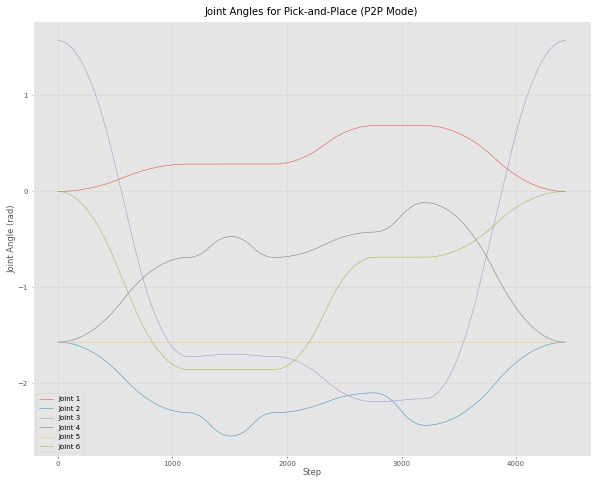

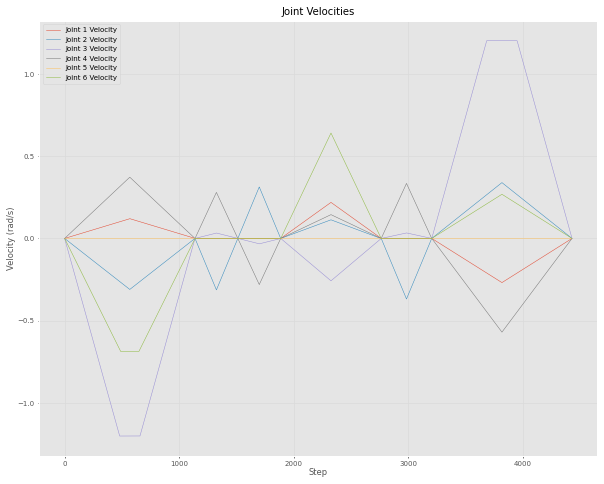

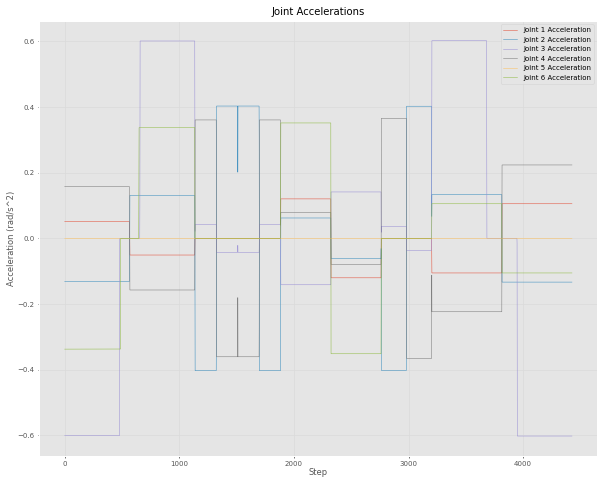

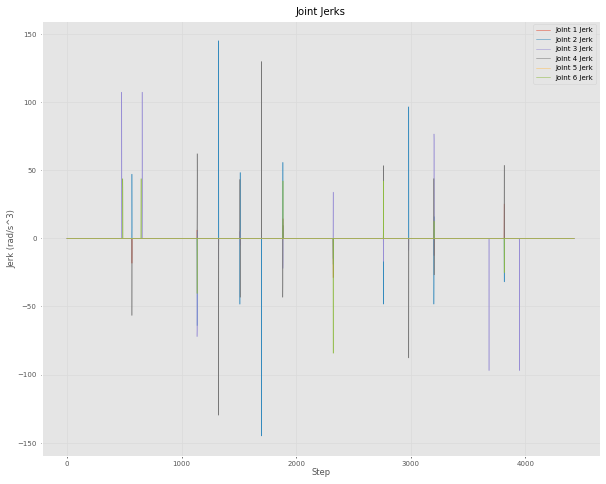

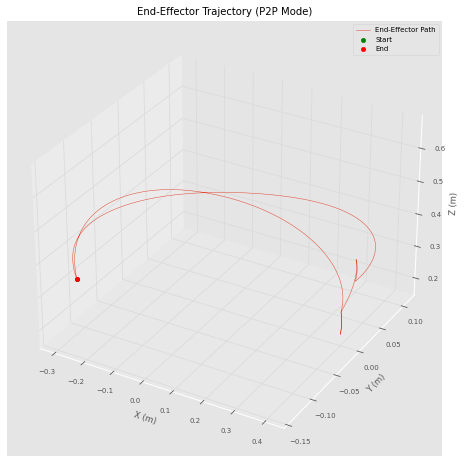

In [9]:
# Convert to a NumPy array for easier processing
full_trajectory = np.array(full_trajectory)
# Calculate velocities, accelerations, and jerks
joint_velocities = np.diff(full_trajectory, axis=0)  # First derivative
joint_velocities = joint_velocities * 240
joint_accelerations = np.diff(joint_velocities, axis=0)  # Second derivative
joint_accelerations = joint_accelerations *240
joint_jerks = np.diff(joint_accelerations, axis=0)  # Third derivative
joint_jerks = joint_jerks * 240
# Plot joint angles over time
plt.figure(figsize=(10, 8))
for i in range(6):  # 6 joints for ur3
    plt.plot(full_trajectory[:, i], label=f'Joint {i+1}')
plt.title('Joint Angles for Pick-and-Place (P2P Mode)')
plt.xlabel('Step')
plt.ylabel('Joint Angle (rad)')
plt.legend()
plt.grid(True)
plt.show()


# Plot joint velocities over time
plt.figure(figsize=(10, 8))
for i in range(joint_velocities.shape[1]):
    plt.plot(joint_velocities[:, i], label=f'Joint {i+1} Velocity')
plt.title('Joint Velocities')
plt.xlabel('Step')
plt.ylabel('Velocity (rad/s)')
plt.legend()
plt.grid(True)
plt.show()

# Plot joint accelerations over time
plt.figure(figsize=(10, 8))
for i in range(joint_accelerations.shape[1]):
    plt.plot(joint_accelerations[:, i], label=f'Joint {i+1} Acceleration')
plt.title('Joint Accelerations')
plt.xlabel('Step')
plt.ylabel('Acceleration (rad/s^2)')
plt.legend()
plt.grid(True)
plt.show()

# Plot joint jerks over time
plt.figure(figsize=(10, 8))
for i in range(joint_jerks.shape[1]):
    plt.plot(joint_jerks[:, i], label=f'Joint {i+1} Jerk')
plt.title('Joint Jerks')
plt.xlabel('Step')
plt.ylabel('Jerk (rad/s^3)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the robot's end-effector position trajectory
end_effector_positions = []
for q in full_trajectory:
    T = ur3.fkine(q)  # Forward kinematics to get end-effector pose
    pos = T.t  # Extract translation (x, y, z) from the SE3 matrix
    end_effector_positions.append(pos)

end_effector_positions = np.array(end_effector_positions)

# Plot the end-effector trajectory in 3D space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(end_effector_positions[:, 0], end_effector_positions[:, 1], end_effector_positions[:, 2], label='End-Effector Path')
ax.scatter(end_effector_positions[0, 0], end_effector_positions[0, 1], end_effector_positions[0, 2], color='green', label='Start')
ax.scatter(end_effector_positions[-1, 0], end_effector_positions[-1, 1], end_effector_positions[-1, 2], color='red', label='End')
ax.set_title('End-Effector Trajectory (P2P Mode)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()
plt.show()

# # Optionally visualize the robot following the full P2P trajectory
# for q in full_trajectory:
#     ur3.plot(q, block=False)

In [3]:
import pybullet as p
import pybullet_data
import time

# Initialize PyBullet physics client
physicsClient = p.connect(p.GUI)  # Use p.DIRECT for non-graphical mode

# Load the ur3 robot
p.setAdditionalSearchPath(pybullet_data.getDataPath())  # Load plane and URDF files
# ur3 = p.loadURDF("/ur3/ur3.urdf", useFixedBase=True)

# plane_id = p.loadURDF("plane.urdf")
table = p.loadURDF("table/table.urdf", [0, 0, -0.63], [0, 0, 0, 1])  # Load a table
block = p.loadURDF("cube_small.urdf", [0.4, 0, 0.02], p.getQuaternionFromEuler([0, 0, 0]))  # Pickable object

ur3 = p.loadURDF(
    "..\\URDFs\\Robots\\Universal_Robots_UR3\\Universal_Robots_UR3.urdf",
    [0, 0, 0],
    p.getQuaternionFromEuler([0, 0, 0]),
    useFixedBase=True,
)

In [11]:



# Get joint indices for ur3
num_joints = p.getNumJoints(ur3)
joint_indices = [i for i in range(num_joints)]



# Set the initial joint positions to the first point in the trajectory
for joint_idx in range(num_joints-1):
    p.resetJointState(ur3, joint_idx, full_trajectory[0][joint_idx])


# Define the full trajectory (make sure this is computed previously)
full_trajectory = np.array(full_trajectory)

# Simulation parameters
time_step = 1.0 / 240.0  # Simulation step size
num_steps = len(full_trajectory)

# Set the simulation time step
p.setTimeStep(time_step)


desired_positions = []
actual_positions = []
actual_velocities = []
actual_accelerations = []

previous_velocities = np.zeros(num_joints)
current_velocities = np.zeros(num_joints)


# Set the robot to its initial pose
p.setJointMotorControlArray(ur3, joint_indices, p.POSITION_CONTROL, targetPositions=np.append(full_trajectory[0], [0]))

for m in range(1):
    # Run the simulation
    for i in range(num_steps):
        # Set joint positions for the current step
        p.setJointMotorControlArray(ur3, joint_indices, p.POSITION_CONTROL, targetPositions=np.append(full_trajectory[i], [0]))


        # Step the simulation
        p.stepSimulation()

        # Read actual joint positions and velocities
        joint_states = p.getJointStates( ur3, joint_indices)
        current_positions = [state[0] for state in joint_states]  # Joint positions
        current_velocities = [state[1] for state in joint_states]  # Joint velocities

        # Compute joint accelerations (finite difference method)
        current_accelerations = (np.array(current_velocities) - np.array(previous_velocities)) / time_step

        # Store the values for plotting
        desired_positions.append(full_trajectory[i])  # Desired positions
        actual_positions.append(current_positions)  # Actual positions
        actual_velocities.append(current_velocities)  # Actual velocities
        actual_accelerations.append(current_accelerations)  # Actual accelerations

        # Update previous velocities for next step
        previous_velocities = current_velocities




        # Optionally, add a small delay to visualize the simulation
        time.sleep(time_step)

# Disconnect from PyBullet
p.disconnect()

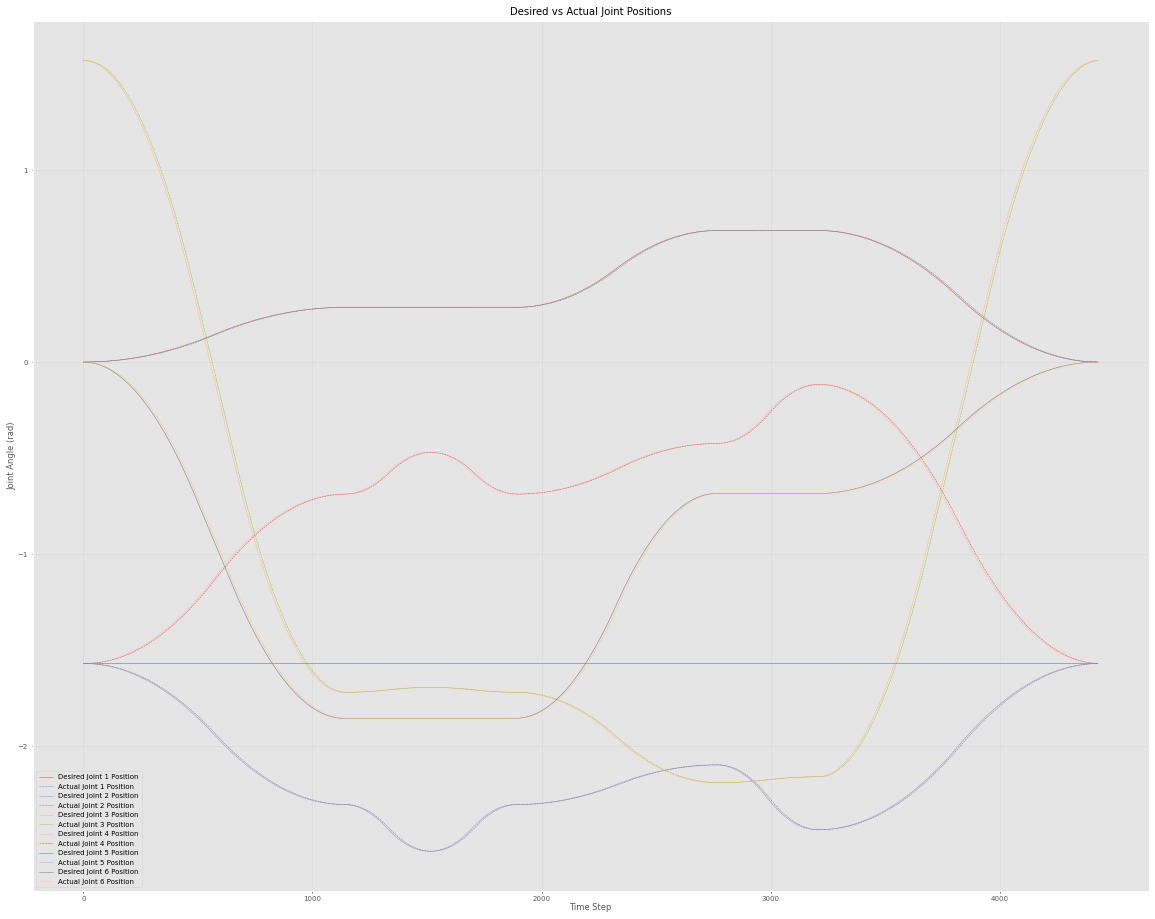

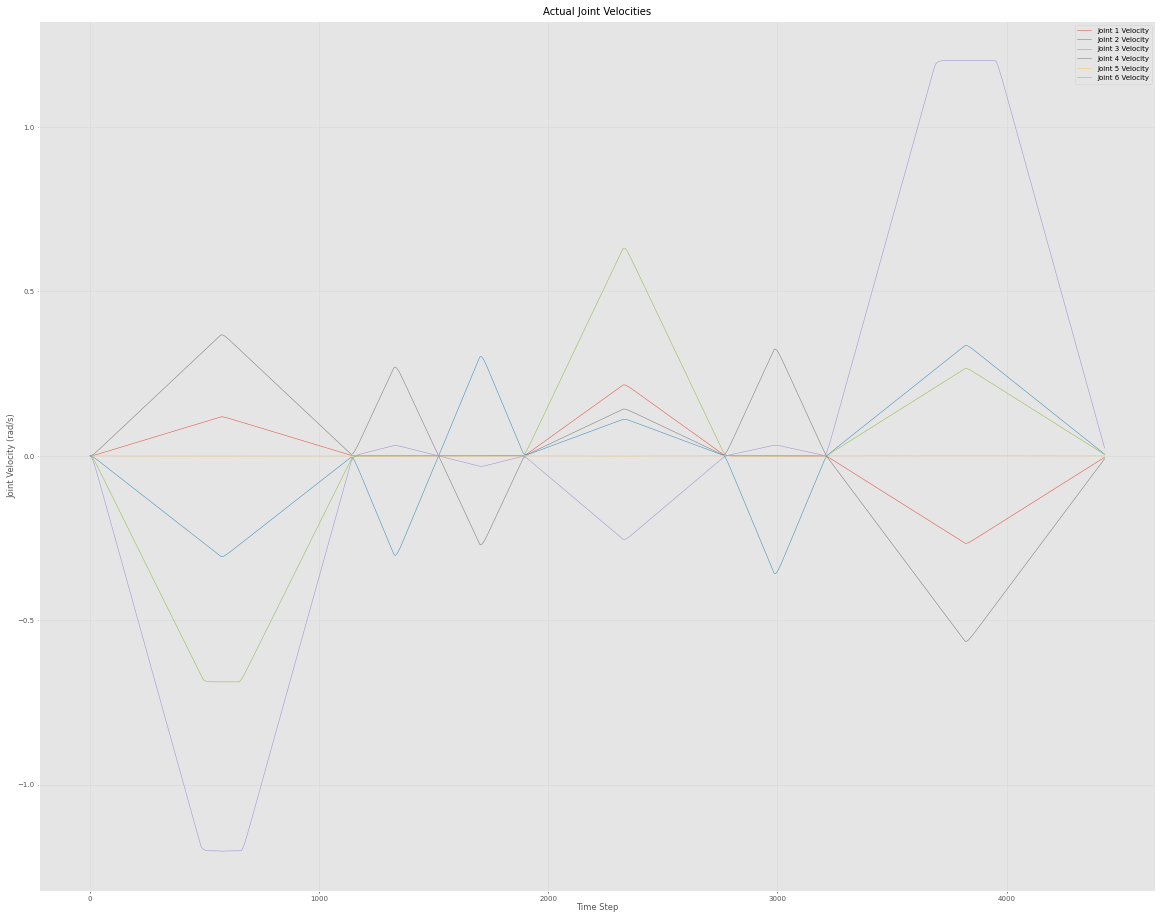

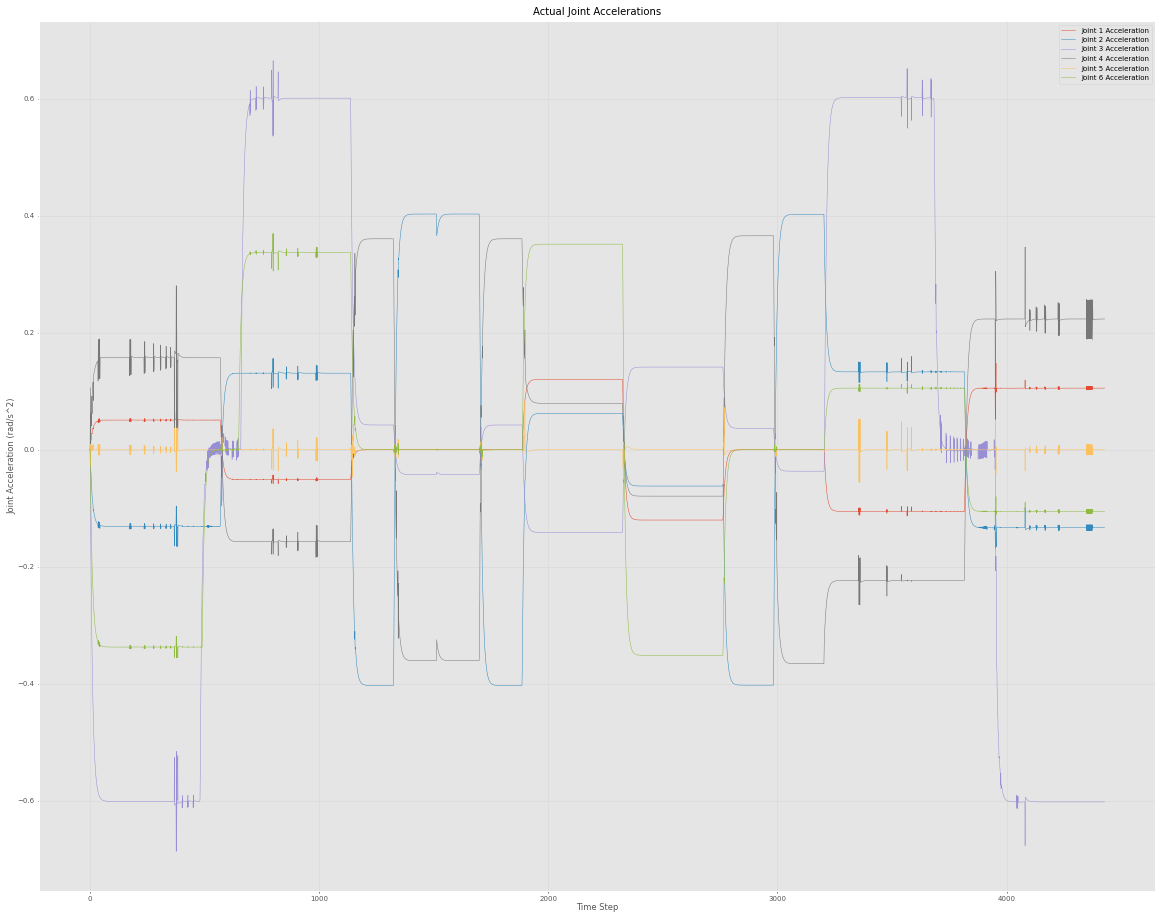

In [12]:

# Convert lists to numpy arrays for easier plotting
desired_positions = np.array(desired_positions)
actual_positions = np.array(actual_positions)
actual_velocities = np.array(actual_velocities)
actual_accelerations = np.array(actual_accelerations)

# Plot desired vs actual joint positions
plt.figure(figsize=(20, 16))
for i in range(num_joints - 1):  # Plot each joint's trajectory
    plt.plot(desired_positions[:, i], label=f'Desired Joint {i+1} Position')
    plt.plot(actual_positions[:, i], '--', label=f'Actual Joint {i+1} Position')
plt.title('Desired vs Actual Joint Positions')
plt.xlabel('Time Step')
plt.ylabel('Joint Angle (rad)')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual joint velocities
plt.figure(figsize=(20, 16))
for i in range(num_joints- 1):  # Plot each joint's velocity
    plt.plot(actual_velocities[:, i], label=f'Joint {i+1} Velocity')
plt.title('Actual Joint Velocities')
plt.xlabel('Time Step')
plt.ylabel('Joint Velocity (rad/s)')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual joint accelerations
plt.figure(figsize=(20, 16))
for i in range(num_joints - 1):  # Plot each joint's acceleration
    plt.plot(actual_accelerations[:, i], label=f'Joint {i+1} Acceleration')
plt.title('Actual Joint Accelerations')
plt.xlabel('Time Step')
plt.ylabel('Joint Acceleration (rad/s^2)')
plt.legend()
plt.grid(True)
plt.show()